In [593]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from johansen import Johansen
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing

In [594]:
#importing price data from shipping companies portfolio


stng = pd.read_csv('STNG.csv')
stng = stng.set_index(pd.DatetimeIndex(stng['Date'].values))

dht = pd.read_csv('DHT.csv')
dht = dht.set_index(pd.DatetimeIndex(dht['Date'].values))

tnk = pd.read_csv('TNK.csv')
tnk = tnk.set_index(pd.DatetimeIndex(tnk['Date'].values))

tnp = pd.read_csv('TNP.csv')
tnp = tnp.set_index(pd.DatetimeIndex(tnp['Date'].values))

fro = pd.read_csv('FRO.csv')
fro = fro.set_index(pd.DatetimeIndex(fro['Date'].values))
print(fro.tail)


<bound method NDFrame.tail of                 Date   Open   High    Low  Close  Adj Close     Volume
2015-11-16  11/16/15  15.20  15.75  14.90  15.75      10.70   197920.0
2015-11-17  11/17/15  15.60  15.65  14.60  15.00      10.19   320860.0
2015-11-18  11/18/15  14.75  14.80  14.10  14.55       9.89   295320.0
2015-11-19  11/19/15  14.70  14.80  14.20  14.40       9.79   197940.0
2015-11-20  11/20/15  14.60  14.70  14.25  14.40       9.79   160660.0
...              ...    ...    ...    ...    ...        ...        ...
2022-02-14   2/14/22   7.54   7.63   7.38   7.52       7.52  1967400.0
2022-02-15   2/15/22   7.49   7.63   7.44   7.59       7.59  1532500.0
2022-02-16   2/16/22   7.56   7.71   7.53   7.70       7.70  2043100.0
2022-02-17   2/17/22   7.85   8.39   7.82   8.23       8.23  4460100.0
2022-02-18   2/18/22   8.20   8.32   7.99   8.06       8.06  2486600.0

[1528 rows x 7 columns]>


In [595]:
#importing price data from Baltic Clean Index and Baltic Dirty Index
bdi = pd.read_csv('BDI.csv')
bdi = bdi.set_index(pd.DatetimeIndex(bdi['Date'].values))

#storing dates from dataset so i can show on graphs x axis. 
dates = bdi['Date']


#importing price data from Baltic Dry Index 
dry_index = pd.read_csv('baltic_dry_index.csv')
dry_index = dry_index.set_index(pd.DatetimeIndex(dry_index['Date'].values))



bci = pd.read_csv('BCI.csv')
bci = bci.set_index(pd.DatetimeIndex(bci['Date'].values))

#to normalize the data need lower and upper bound we need to average the min and max from BCI and BDI

#the lower bound 
lower_bound = (min(bdi['Open']) + min(bci['Open']))/2

#the higher bound
upper_bound = (max(bdi['Open']) + max(bci['Open']))/2


#normalizing the baltic dry index along the specified bounds 
scaler = preprocessing.minmax_scale(dry_index['Open'], feature_range=(lower_bound, upper_bound))
dry_index['Open'] = scaler

#removing extraneous data from dry_index 
dry_index = dry_index['Open']


#to make the data start from 2015 instead of 2021 (that's how it store in csv) and going back in time
bdi = bdi[::-1]['Open']
bci = bci[::-1]['Open']

print(bdi)

#averaging the daily baltic dirty index,  baltic clean index prices and baltic dry index 
bti = (bdi + bci + dry_index) / 3
print(bti)

2015-11-16    863
2015-11-17    871
2015-11-18    879
2015-11-19    883
2015-11-20    887
             ... 
2022-02-14    690
2022-02-15    691
2022-02-16    692
2022-02-17    694
2022-02-18    699
Name: Open, Length: 1528, dtype: int64
2015-11-16    863
2015-11-17    871
2015-11-18    879
2015-11-19    883
2015-11-20    887
             ... 
2022-02-14    690
2022-02-15    691
2022-02-16    692
2022-02-17    694
2022-02-18    699
Name: Open, Length: 1528, dtype: int64


In [596]:
def five_day_sma(data, period, column):
    return data[column].rolling(window=period).mean() 

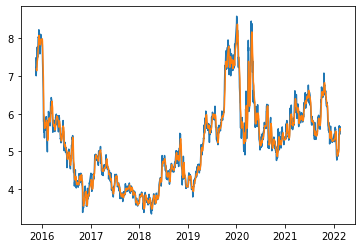

In [597]:
#to get average weekly prices

avg_dht = five_day_sma(dht, 5, 'Close')
avg_stng = five_day_sma(stng, 5, 'Close')
avg_tnk = five_day_sma(tnk, 5, 'Close')
avg_tnp = five_day_sma(tnp, 5, 'Close')
avg_fro = five_day_sma(fro, 5, 'Close')

data = bti.rolling(window=5).mean()

plt.plot(dht['Close'])
plt.plot(avg_dht)

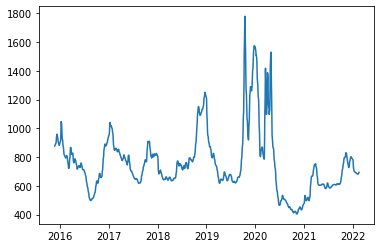

In [598]:
plt.plot(data)

In [599]:
#due to the calculation of the average weekly prices, the first 4 data points are NaN 
#so adjusting for that in the tanker shipping company data and the index data 

X_train =  avg_tnk[4:] 
y_train = data.iloc[4:]


df_train = pd.DataFrame({'x':X_train, 'y': y_train})

#calculating optimal lag length 
r = adfuller(X_train, autolag='AIC')
optimal_lag = round(r[2], 4)
print(optimal_lag)

vec_rank1 = select_coint_rank(df_train, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank1.summary())

23
Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          85.95          23.15
  1   2          17.91          6.635
-------------------------------------


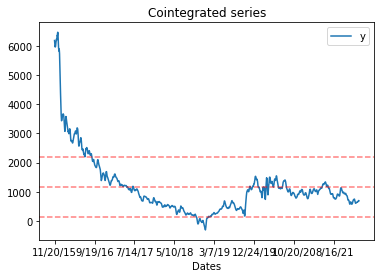

In [600]:
#ordering eigenvalues and eigenvetors so they go from highest eigenvalue to lowest 

eigenvalues = coint_johansen(df_train, 0, 23).eig
eigenvectors = coint_johansen(df_train, 0, 23).evec

indices_ordered = np.argsort(eigenvalues)
indices_ordered = np.flipud(indices_ordered)
eigenvalues = eigenvalues[indices_ordered]


eigenvectors = eigenvectors[:, indices_ordered]


#getting the egivector related to the highest eigenvalue 
vec = eigenvectors[:, 0]
vec_min = np.min(np.abs(vec))

vec = vec / vec_min



#from training data
portfolio_insample = np.dot(df_train, vec)


training_data_plotted = {'Dates': dates[::-1][4:], 'y': portfolio_insample}


df_train_plot = pd.DataFrame(training_data_plotted,columns=['Dates','y'])


#the y axis represents the dot product of the eigenvector and the index and tanker company  
df_train_plot.plot(title="Cointegrated series", x ='Dates', y='y')


# In sample mean and std. 
in_sample = np.dot(df_train, vec)
mean = np.mean(in_sample)
std = np.std(in_sample)

plt.axhline(y=mean - std, color='r', ls='--', alpha=.5)
plt.axhline(y=mean, color='r', ls='--', alpha=.5)
plt.axhline(y=mean + std, color='r', ls='--', alpha=.5)






In [601]:
#now generating signals using moving averages


#on the df_train_plot we have to run the moving averages thing 

# create 42 days simple moving average column
df_train_plot['42_SMA'] = df_train_plot['y'].rolling(window = 30, min_periods = 1).mean()
#df_train_plot['42_SMA'] = df_train_plot['y'].ewm(span = 50, adjust = False).mean()


# create 7 days simple moving average column
df_train_plot['7_SMA'] = df_train_plot['y'].rolling(window = 10, min_periods = 1).mean()

#df_train_plot['7_SMA'] = df_train_plot['y'].ewm(span = 20, adjust = False).mean()



# display first few rows
df_train_plot.head()


df_train_plot['Signal'] = 0.0
df_train_plot['Signal'] = np.where(df_train_plot['7_SMA'] > df_train_plot['42_SMA'], 1.0, 0.0)


df_train_plot['Position'] = df_train_plot['Signal'].diff()
# display first few rows
df_train_plot.head()

,Dates,y,42_SMA,7_SMA,Signal,Position
2015-11-20,11/20/15,6180.739285,6180.739285,6180.739285,0.0,NaN
2015-11-23,11/23/15,6075.285949,6128.012617,6128.012617,0.0,0.0
2015-11-24,11/24/15,6020.274444,6092.099892,6092.099892,0.0,0.0
2015-11-25,11/25/15,5958.784246,6058.770981,6058.770981,0.0,0.0
2015-11-27,11/27/15,5986.099018,6044.236588,6044.236588,0.0,0.0


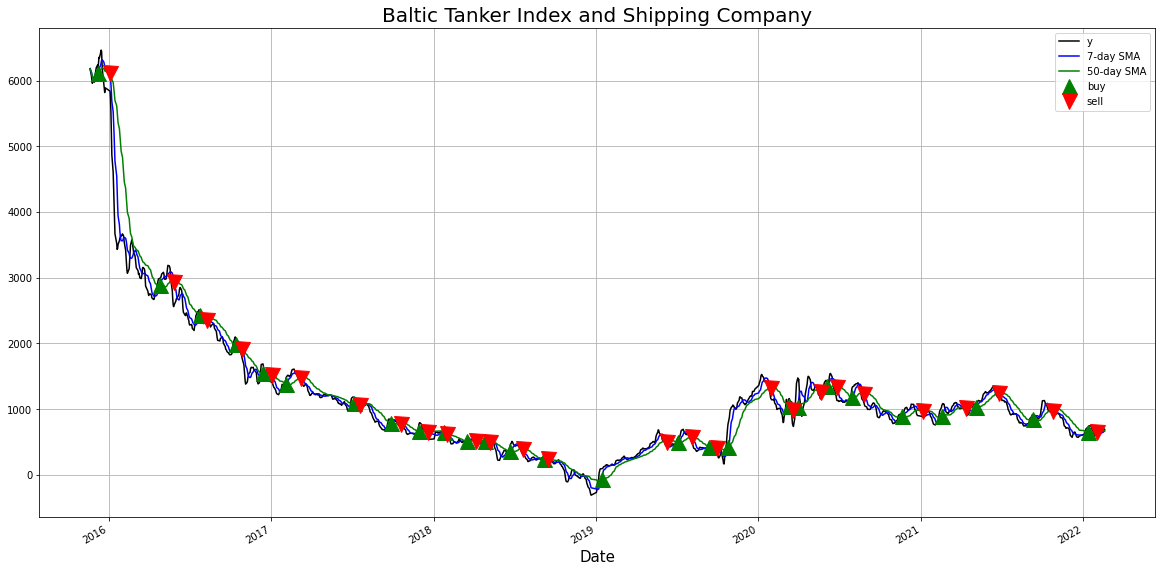

               Dates            y       42_SMA        7_SMA  Signal  Position
2015-12-09   12/9/15  6263.822165  6110.720098  6116.306160     1.0       1.0
2016-04-26   4/26/16  3001.063636  2877.791808  2886.243163     1.0       1.0
2016-07-25   7/25/16  2496.308323  2420.222127  2426.450596     1.0       1.0
2016-10-14  10/14/16  2026.846612  1972.879497  1991.340597     1.0       1.0
2016-12-14  12/14/16  1648.278503  1537.402593  1548.157376     1.0       1.0
2017-02-03    2/3/17  1481.547257  1375.522271  1389.320851     1.0       1.0
2017-07-06    7/6/17  1171.226457  1089.070735  1091.681749     1.0       1.0
2017-09-27   9/27/17   841.901745   783.841715   792.992357     1.0       1.0
2017-11-30  11/30/17   793.635339   672.943520   673.583388     1.0       1.0
2018-01-24   1/24/18   631.699123   645.915395   646.215358     1.0       1.0
2018-03-16   3/16/18   550.652321   512.206813   513.840504     1.0       1.0
2018-04-27   4/27/18   508.658856   511.316399   511.701314     

In [602]:
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 

df_train_plot['y'].plot(color = 'k', label= 'y')

df_train_plot['7_SMA'].plot(color = 'b',label = '7-day SMA') 

df_train_plot['42_SMA'].plot(color = 'g', label = '50-day SMA')


# plot ‘buy’ signals
plt.plot(df_train_plot[df_train_plot['Position'] == 1].index, 
         df_train_plot['7_SMA'][df_train_plot['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(df_train_plot[df_train_plot["Position"] == -1].index, 
         df_train_plot['7_SMA'][df_train_plot['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')

plt.xlabel('Date', fontsize = 15 )
plt.title('Baltic Tanker Index and Shipping Company', fontsize = 20)
plt.legend()
plt.grid()
plt.show()


buys = df_train_plot[df_train_plot['Position'] == 1]
sells =  df_train_plot[df_train_plot['Position'] == -1]

var = df_train_plot[df_train_plot['Position'] == -1]
print(buys)

#problem that needs to be resolved is that in the stock companies the dates are stored
#as yr-mm-dd, whereas in the buy and sell signals the  date variable form, so I just need to append the date colum
#to the tanker company 

# for smth in buys['Dates']:
#     print(avg_stng['Date'].index(buys[smth]))

#getting the upper bound for for loop from the signals at the point when we aren't in a trade
#tryna see the average time we in a trade 

# time = [] 
# for i in range(min(len(buys),len(sells))+1):
    
    
    

# The following has the sharpe and returns function.

2015-11-20    NaN
2015-11-23    0.0
2015-11-24    0.0
2015-11-25    0.0
2015-11-27    0.0
             ... 
2022-02-14    0.0
2022-02-15    0.0
2022-02-16    0.0
2022-02-17    0.0
2022-02-18    0.0
Name: Position, Length: 1524, dtype: float64
sharpe ratio is: 0.4391991143102543
None


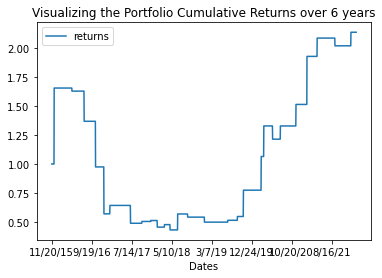

In [604]:
#now calculating returns and sharpe 

def sharpe(rtrns):
    rfr = .02
    mean = np.mean(rtrns)
    std = np.std(rtrns)
    annulized_sharpe = (mean*252 - rfr)/(std * (252**0.5))
    return annulized_sharpe

print(df_train_plot['Position'])


#when putting a company name, also go to where the dataframe with X_train was being made and change the 
#company name there too 

#px['Daily P&L'] = px['Adj Close'].diff() * px['Signals']

def returns(company):
    rtrns = []
    for idx, num in enumerate(df_train_plot['Position']):
        #rtrns.appens()
        if num == 0:
            rtrns.append(0)
        elif num == 1: 
            start_s1 = company[4:][idx]
            close_s1 = company[4:][idx+1]
            daily_return = (close_s1-start_s1)/start_s1
            rtrns.append(daily_return)
        else: #like the cases where num = -1 
            rtrns.append(0)
#             start_s1 = company[4:][idx]
#             close_s1 = company[4:][idx+1]
#             #daily_return = start_s1-close_s1
#             daily_return = (-1 * (close_s1-start_s1))/start_s1
#             rtrns.append(daily_return)
        
    return rtrns 
print("sharpe ratio is: " + str(sharpe(returns(avg_tnk))))

#retuens function was still coming out negative when i had set the moving averages to 30 and 6 or 30 and 1 forgot 


def plot_graph(company): 
    df_cum_returns = {'Dates': dates[::-1][4:], 'returns': (np.add(1,returns(company))).cumprod()}
    df_final_returns = pd.DataFrame(df_cum_returns, columns=['Dates', 'returns'])
    df_final_returns.plot(title="Visualizing the Portfolio Cumulative Returns over 6 years", x ='Dates', y='returns')

print(plot_graph(avg_tnk))
    

